# Preliminary operations

We import the libraries and the drive environment.

In [1]:
!pip install folium
!pip install geopandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 78.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 45.6 MB/s eta 0:00:00


In [2]:
# Utility
from google.colab import drive
import pandas as pd
import numpy as np
from shutil import copyfile, copy
import datetime
import os
import json

# Viz
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from matplotlib.colors import ListedColormap

# Geo
import folium
import geopandas as gpd

In [3]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
pd.set_option('display.max_columns', None)

# Problem definition

We try to estimate the e-scooter demand by relating the e-scooters availability (computed as the hourly difference between pick-ups and drop-offs for each zone) with the e-scooters usage (computed as the hourly average time between consecutives pick-ups for each zone).

In [5]:
df = pd.read_csv('/content/gdrive/MyDrive/DSLSC/motoscooter_movimento_new.csv')

In [6]:
df.columns

Index(['provider_id', 'lat', 'lng', 'created_at', 'distance', 'placename',
       'placelat', 'placelon', 'lat&lng', 'prevObservation', 'nextObservation',
       'nextCreated_at', 'nextDistance', 'nextTimeDiff', 'prevCreated_at',
       'prevDistance', 'prevTimeDiff', 'samePlace', 'type'],
      dtype='object')

In [7]:
df['created_at'] =  pd.to_datetime(df['created_at'], format = '%Y%m%d %H:%M:%S')
df['nextCreated_at'] =  pd.to_datetime(df['nextCreated_at'], format = '%Y%m%d %H:%M:%S')
df['prevCreated_at'] =  pd.to_datetime(df['prevCreated_at'], format = '%Y%m%d %H:%M:%S')
# Remove waiting long e-scooters
df = df[df['type'] != 'waiting long']

In [8]:
df = df.sort_values('created_at')
df = df.reset_index(drop = True)

First of all we need to join the dataframe with the Milan zones.

In [9]:
gdf = gpd.GeoDataFrame(df, crs = 'EPSG:4326', geometry = gpd.points_from_xy(df.placelon, df.placelat))

In [10]:
milan_nil = gpd.read_file("/content/gdrive/MyDrive/DSLSC/NIL_E0.zip")

In [11]:
# Ensuring the crs is the same
if gdf.crs != milan_nil.crs:
  milan_nil = milan_nil.to_crs(gdf.crs)

In [12]:
# Spatial join between the zones and scooters GeoDataFrames
zones_with_scooters_gdf = gpd.sjoin(milan_nil, gdf, predicate = 'contains')
# Group the GeoDataFrame by zone ID and count the number of scooters in each zone
scooter_counts_by_zone = zones_with_scooters_gdf.groupby('NIL').size()
# Get the IDs of the zones with scooters
zones_with_scooters_ids = scooter_counts_by_zone.index
# Filter the zones GeoDataFrame in order to remove the zones without scooters
zones_gdf = milan_nil[milan_nil['NIL'].isin(zones_with_scooters_ids)]
zones_gdf = zones_gdf.reset_index(drop = True)

In [13]:
zones_with_scooters_gdf.reset_index(drop = True, inplace = True)

In [14]:
keyList = list(zones_with_scooters_gdf['NIL'].unique())
place_dict = {key: [] for key in keyList}
for i in range(0, len(zones_with_scooters_gdf)):
  if not isinstance(zones_with_scooters_gdf['placename'][i], str):
    place_dict[zones_with_scooters_gdf['NIL'][i]].append(zones_with_scooters_gdf['placename'][i])

In [15]:
for key, value in place_dict.items():
  value = list(set(value))
  place_dict[key] = value

In [16]:
for i in range(0, len(df)):
  for key, value in place_dict.items():
    if df['placename'][i] in value:
      df['placename'][i] = key
      break 

<ipython-input-16-15211a2a841e>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['placename'][i] = key


## Scooters availability

We compute the first operator: the availability of the e-scooters for each zone. For each hour we compute the number of e-scooters left in each specific zone. So, we group the dataset by NIL and by hours. Starting from midnight, where the count is 0 for each zone, we iterate over each subgroup, adding 1 to the count if the e-scooter is left (drop-off) and subtracting 1 elsewhere (pick-up).

In [17]:
pickup = ['first seen / pick-up', 'pick-up', 'pick-up outlier']
dropoff = ['last seen / drop-off', 'drop-off', 'drop-off outlier']

In [18]:
df['remaining'] = 0*len(df)
groups = df.groupby('placename')
count_df = []
# Grouping by NIL
for name, group in groups:
  group = group.reset_index(drop = True)
  first = True
  # Selecting each hour in the group
  for t in range(0, 24):
    group_hour = group[group['created_at'].dt.hour == t].reset_index(drop = True)
    if not group_hour.empty:
      # Start from 0 if it's the first observation
      if(first == True):
        count = 0
        first = False
      # Else esume the previous hour count 
      else:
        count = prev
      # Compute the e-scooters difference
      for i in range(0, len(group_hour)):
        if(group_hour['type'][i] in pickup):
          count-=1
        elif(group_hour['type'][i] in dropoff):
          count+=1
      group_hour['remaining'] = [count]*len(group_hour)
      count_df.append(pd.DataFrame(group_hour))
      prev = count    

In [19]:
combined_df = pd.concat(count_df)
df = combined_df.sort_values(by = 'created_at').reset_index(drop = True)

In [20]:
df_rem = df[['created_at', 'placename', 'placelat', 'placelon', 'remaining', 'type']]
df_rem['hour'] = pd.to_datetime(df_rem['created_at']).dt.hour

<ipython-input-20-486a0b76fa76>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rem['hour'] = pd.to_datetime(df_rem['created_at']).dt.hour


In [21]:
# Filling missing values for midnight
different_values = np.setxor1d(df_rem['placename'].unique(), df[df_rem['hour'] == 0]['placename'].unique())
for el in different_values:
  lat = df_rem[df_rem['placename'] == el]['placelat'].values[0]
  lon = df_rem[df_rem['placename'] == el]['placelon'].values[0]
  df_rem.loc[len(df_rem)] = ['2019-12-02 00:00:00', el, lat, lon, 0, 'added', 0]

<ipython-input-21-493dbcc848a8>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rem.loc[len(df_rem)] = ['2019-12-02 00:00:00', el, lat, lon, 0, 'added', 0]
<ipython-input-21-493dbcc848a8>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rem.loc[len(df_rem)] = ['2019-12-02 00:00:00', el, lat, lon, 0, 'added', 0]
<ipython-input-21-493dbcc848a8>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rem.loc[len(df_rem)] = ['2019-12-02

In [22]:
df_rem['created_at'] = pd.to_datetime(df_rem['created_at'], format = '%Y%m%d %H:%M:%S')
df_rem = df_rem.sort_values('created_at').reset_index(drop = True)

<ipython-input-22-5af09a8f1980>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rem['created_at'] = pd.to_datetime(df_rem['created_at'], format = '%Y%m%d %H:%M:%S')


In [23]:
df_rem

,created_at,placename,placelat,placelon,remaining,type,hour
0,2019-12-02 00:00:00,S. SIRO,45.47955,9.13915,0,added,0
1,2019-12-02 00:00:00,GIARDINI PORTA VENEZIA,45.47485,9.20025,0,added,0
2,2019-12-02 00:00:00,QT 8,45.48425,9.13915,0,added,0
3,2019-12-02 00:10:10,S. CRISTOFORO,45.44665,9.14855,-4,first seen / pick-up,0
4,2019-12-02 00:10:10,S. CRISTOFORO,45.44665,9.14855,-4,first seen / pick-up,0
...,...,...,...,...,...,...,...
81566,2019-12-08 23:55:28,TRE TORRI,45.47955,9.15325,6,last seen / drop-off,23
81567,2019-12-08 23:55:28,PORTELLO,45.48895,9.15325,-5,last seen / drop-off,23
81568,2019-12-08 23:55:29,WASHINGTON,45.46545,9.15325,-18,last seen / drop-off,23
81569,2019-12-08 23:55:29,WASHINGTON,45.46075,9.15325,-18,last seen / drop-off,23


We can take just one observation for each zone and hour (we have hourly information!).

In [24]:
groups = df_rem.groupby('placename')
final_list = []
for name, group in groups:
  groups_2 = group.groupby('hour')
  for name, group_2 in groups_2:
    final_list.append(group_2.iloc[0])

In [25]:
df_rem = pd.DataFrame(final_list)

In [26]:
df_rem = df_rem.sort_values('created_at').reset_index(drop = True)

In [27]:
# Filling missing values for each hour with the last observation
for name, group in df_rem.groupby('hour'):
  last_known_values = df_rem[df_rem['hour'] <= name].groupby('placename')['remaining'].last()
  different_values = np.setxor1d(df_rem['placename'].unique(), df_rem[df_rem['hour'] == name]['placename'].unique())
  for el in different_values:
    lat = df_rem[df_rem['placename'] == el]['placelat'].values[0]
    lon = df_rem[df_rem['placename'] == el]['placelon'].values[0]
    df_rem.loc[len(df_rem)] = ['2019-12-02 ' + str(name) + ':00:00', el, lat, lon, last_known_values[el], 'added', name]

In [28]:
df_rem

,created_at,placename,placelat,placelon,remaining,type,hour
0,2019-12-02 00:00:00,GIARDINI PORTA VENEZIA,45.47485,9.20025,0,added,0
1,2019-12-02 00:00:00,QT 8,45.48425,9.13915,0,added,0
2,2019-12-02 00:00:00,S. SIRO,45.47955,9.13915,0,added,0
3,2019-12-02 00:10:10,S. CRISTOFORO,45.44665,9.14855,-4,first seen / pick-up,0
4,2019-12-02 00:10:11,BANDE NERE,45.46545,9.13915,2,first seen / pick-up,0
...,...,...,...,...,...,...,...
979,2019-12-02 21:00:00,S. SIRO,45.47955,9.13915,0,added,21
980,2019-12-02 22:00:00,QT 8,45.48425,9.13915,0,added,22
981,2019-12-02 22:00:00,S. SIRO,45.47955,9.13915,0,added,22
982,2019-12-02 23:00:00,CITTA' STUDI,45.47955,9.22375,1,added,23


In [29]:
df_rem['created_at'] = pd.to_datetime(df_rem['created_at'], format = '%Y%m%d %H:%M:%S')
df_rem = df_rem.sort_values('created_at').reset_index(drop = True)

In [30]:
gdf_rem = gpd.GeoDataFrame(df_rem, crs = 'EPSG:4326', geometry = gpd.points_from_xy(df_rem.placelon, df_rem.placelat))

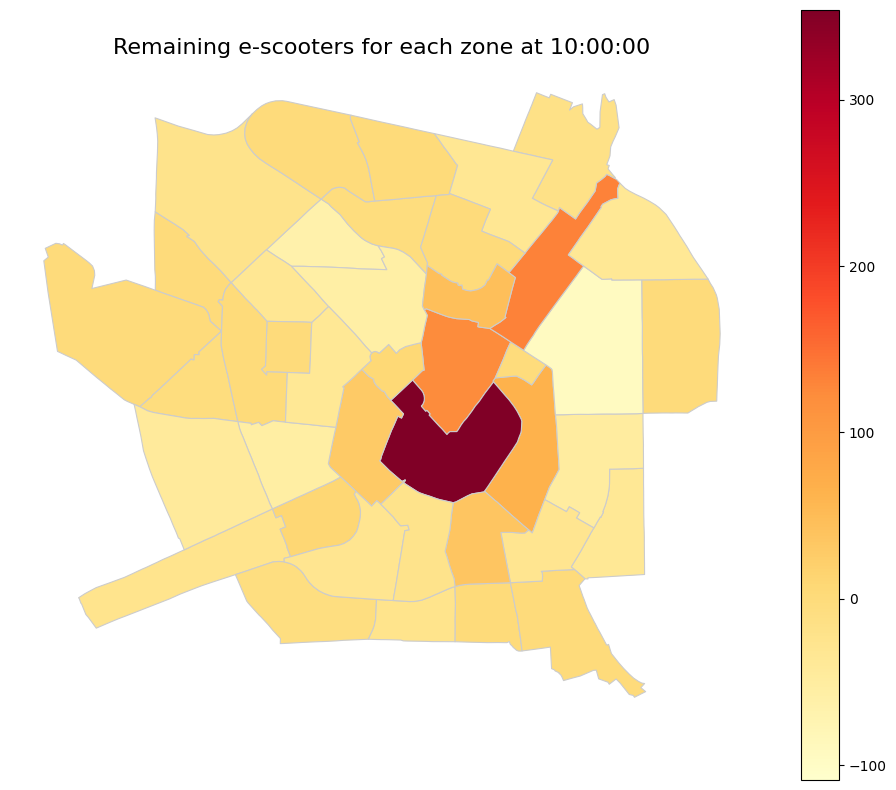

In [31]:
vmin = gdf_rem['remaining'].min()
vmax = gdf_rem['remaining'].max()

# Filter the DataFrame for the specific hour
specific_hour = 10
df_specific_hour = gdf_rem[gdf_rem['hour'] == specific_hour]

# Merge the filtered GeoDataFrame with the milan_nil GeoDataFrame
merged = gpd.sjoin(milan_nil, df_specific_hour, predicate = 'contains')

# Plot the choropleth map
fig, ax = plt.subplots(figsize = (12, 10))
merged.plot(column = 'remaining', cmap = 'YlOrRd', linewidth = 0.8, ax = ax, edgecolor = '0.8', legend = True, norm = plt.Normalize(vmin = vmin, vmax = vmax))

# Set the plot title and axis labels
plt.title('Remaining e-scooters for each zone at ' + str(specific_hour) + ':00:00', fontsize = 16)
ax.set_axis_off()

# Display the map
plt.show()

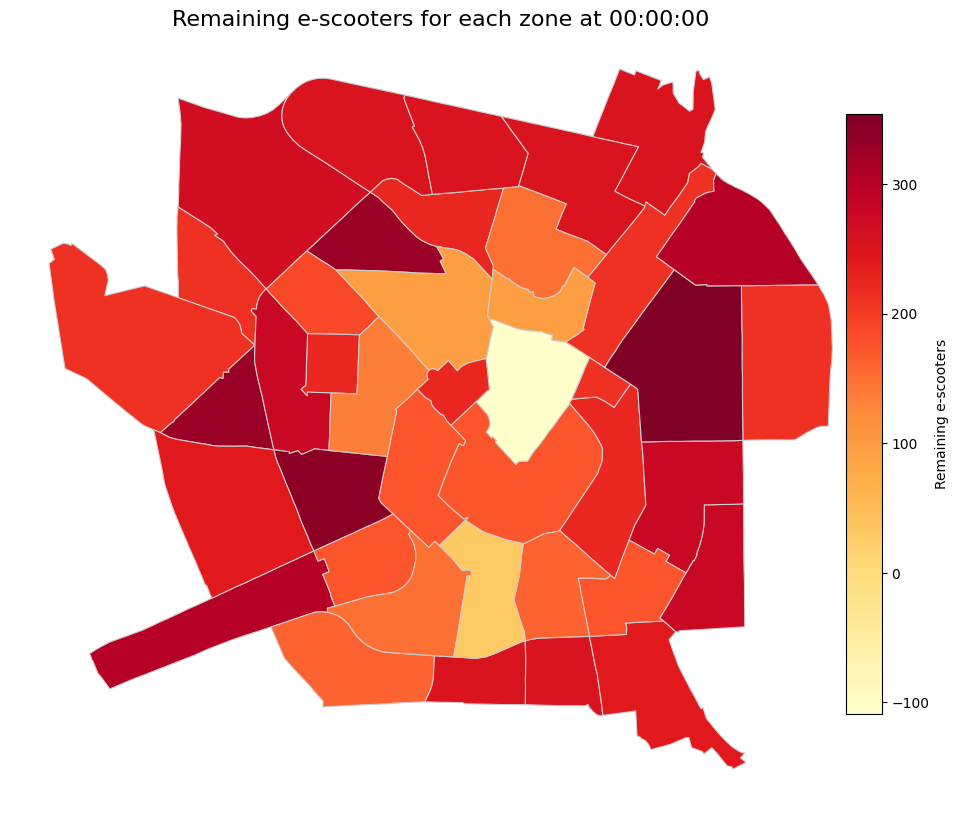

In [32]:
# Create a figure and axes for the map
fig, ax = plt.subplots(figsize = (12, 10))

vmin = gdf_rem['remaining'].min()
vmax = gdf_rem['remaining'].max()

# Define a function to update the map for each hour
def update_map(hour):
  ax.clear()
  df_specific_hour = gdf_rem[gdf_rem['hour'] == hour]
  merged = gpd.sjoin(milan_nil, df_specific_hour, predicate = 'contains')
  merged = merged[merged['hour'] == hour]
  merged.plot(column = 'remaining', cmap = 'YlOrRd', linewidth = 0.8, ax = ax, edgecolor = '0.8', legend = False)
  ax.set_title('Remaining e-scooters for each zone at {}:00:00'.format(str(hour).zfill(2)), fontsize = 16)
  ax.set_axis_off()

# Create the animated map
ani = animation.FuncAnimation(fig, update_map, frames = range(0, 24), interval = 750, repeat = True)

# Add a colorbar
cax = fig.add_axes([0.85, 0.2, 0.03, 0.6])
sm = plt.cm.ScalarMappable(cmap = 'YlOrRd', norm = plt.Normalize(vmin = vmin, vmax = vmax))
sm.set_array([])
fig.colorbar(sm, cax = cax)
cax.set_ylabel('Remaining e-scooters')

# Set up the writer and save the animation to an MP4 file
Writer = animation.writers['ffmpeg']
writer = Writer(fps = 1, metadata = dict(artist = 'Me'), bitrate = 1800)
# Set the aspect ratio to a finite positive value
ax.set_aspect('equal', adjustable = 'box')
ani.save('remaining scooters.mp4', writer = writer)

## Scooters effective availability

Now we put in relation the scooters availability with the hourly average request, computed as the time between consecutive pick-ups in the same zone.

In [33]:
pickup = ['first seen / pick-up', 'pick-up', 'pick-up outlier']
dropoff = ['last seen / drop-off', 'drop-off', 'drop-off outlier']

In [34]:
# Selecting only pick-ups observations
df_p = df[df['type'].isin(pickup)]
df_p = df_p.reset_index(drop = True)
df_p['time_diff'] = 0*len(df_p)

In [35]:
groups = df_p.groupby('placename')
time_diff_df = []
# Grouping by NIL
for name, group in groups:
  group = group.sort_values('created_at').reset_index(drop = True)
  # For each NIL compute the time difference between two consecutive pick-ups
  for i in range(1, len(group)):
    diff = group['created_at'][i] - group['created_at'][i-1]
    group['time_diff'][i] = diff.total_seconds()
  time_diff_df.append(group)

<ipython-input-35-82711dae6e73>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['time_diff'][i] = diff.total_seconds()


In [36]:
combined_df = pd.concat(time_diff_df)
df_p = combined_df.reset_index(drop = True)

In [37]:
df_p['time_diff_avg'] = 0*len(df_p)
groups = df_p.groupby('placename')
avg_df = []
# Grouping by NIL
for name, group in groups:
  group = group.reset_index(drop = True)
  # Selecting each hour in the group
  for t in range(0, 24):
    group_hour = group[group['created_at'].dt.hour == t].reset_index(drop = True)
    if not group_hour.empty:
      # Compute the avearege time difference between two consecutive pick-up for each hour
      avg = group_hour['time_diff'].mean()
      group_hour['time_diff_avg'] = [avg]*len(group_hour)
      avg_df.append(pd.DataFrame(group_hour))

In [38]:
combined_df = pd.concat(avg_df)
df_p = combined_df.sort_values('created_at').reset_index(drop = True)
df_avg = df_p[['created_at', 'placename', 'placelat', 'placelon', 'remaining', 'type', 'time_diff_avg']]
df_avg['hour'] = pd.to_datetime(df_avg['created_at']).dt.hour

<ipython-input-38-34ba2d217e71>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_avg['hour'] = pd.to_datetime(df_avg['created_at']).dt.hour


In [39]:
# Filling missing values for midnight
different_values = np.setxor1d(df_avg['placename'].unique(), df_p[df_avg['hour'] == 0]['placename'].unique())
for el in different_values:
  lat = df_avg[df_avg['placename'] == el]['placelat'].values[0]
  lon = df_avg[df_avg['placename'] == el]['placelon'].values[0]
  diff = df_avg[df_avg['placename'] == el]['time_diff_avg'].values[0]
  df_avg.loc[len(df_avg)] = ['2019-12-02 00:00:00', el, lat, lon, 0, 'added', diff, 0]

<ipython-input-39-148744343f94>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_avg.loc[len(df_avg)] = ['2019-12-02 00:00:00', el, lat, lon, 0, 'added', diff, 0]
<ipython-input-39-148744343f94>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_avg.loc[len(df_avg)] = ['2019-12-02 00:00:00', el, lat, lon, 0, 'added', diff, 0]
<ipython-input-39-148744343f94>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_avg.loc[len(df_avg)] = 

In [40]:
df_avg['created_at'] = pd.to_datetime(df_avg['created_at'], format = '%Y%m%d %H:%M:%S')
df_avg = df_avg.sort_values('created_at').reset_index(drop = True)

<ipython-input-40-70134c8779bb>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_avg['created_at'] = pd.to_datetime(df_avg['created_at'], format = '%Y%m%d %H:%M:%S')


In [41]:
df_avg

,created_at,placename,placelat,placelon,remaining,type,time_diff_avg,hour
0,2019-12-02 00:00:00,S. SIRO,45.47955,9.13915,0,added,0.000000,0
1,2019-12-02 00:00:00,GIARDINI PORTA VENEZIA,45.47485,9.20025,0,added,25199.333333,0
2,2019-12-02 00:00:00,BOVISA,45.49835,9.16735,0,added,4950.833333,0
3,2019-12-02 00:00:00,QT 8,45.48425,9.13915,0,added,0.000000,0
4,2019-12-02 00:10:10,S. CRISTOFORO,45.44665,9.14855,-4,first seen / pick-up,795.058824,0
...,...,...,...,...,...,...,...,...
40783,2019-12-08 23:40:29,WASHINGTON,45.46075,9.16265,-18,pick-up,337.075000,23
40784,2019-12-08 23:40:30,TRE TORRI,45.47485,9.15325,6,pick-up,1887.500000,23
40785,2019-12-08 23:40:31,PORTELLO,45.48895,9.15325,-5,pick-up,715.512821,23
40786,2019-12-08 23:40:32,WASHINGTON,45.46075,9.15325,-18,pick-up,337.075000,23


We can take just one observation for each zone and hour (we have hourly information!).

In [42]:
groups = df_avg.groupby('placename')
final_list = []
for name, group in groups:
  groups_2 = group.groupby('hour')
  for name, group_2 in groups_2:
    final_list.append(group_2.iloc[0])

In [43]:
df_avg = pd.DataFrame(final_list)
df_avg = df_avg.sort_values('created_at').reset_index(drop = True)

In [44]:
# Filling missing values for each hour with the last observation
for name, group in df_avg.groupby('hour'):
  last_known_values = df_avg[df_avg['hour'] <= name].groupby('placename')['remaining'].last()
  different_values = np.setxor1d(df_avg['placename'].unique(), df_avg[df_avg['hour'] == name]['placename'].unique())
  for el in different_values:
    lat = df_avg[df_avg['placename'] == el]['placelat'].values[0]
    lon = df_avg[df_avg['placename'] == el]['placelon'].values[0]
    df_avg.loc[len(df_avg)] = ['2019-12-02 ' + str(name) + ':00:00', el, lat, lon, 0, 'added', diff, name]

time_diff_avg == 0 and time_diff_avg == 3600 means that in that specific hour there were no pick-up, so we assign them the maximum value of seconds in an hour without picking up an e-scooter, i.e. 3600.


In [45]:
for i in range(len(df_avg)):
  if(df_avg['time_diff_avg'][i] > 3600):
    df_avg['time_diff_avg'][i] = 3600
  if(df_avg['time_diff_avg'][i] == 0):
    df_avg['time_diff_avg'][i] = 3600

<ipython-input-45-40119696a0ff>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_avg['time_diff_avg'][i] = 3600
<ipython-input-45-40119696a0ff>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_avg['time_diff_avg'][i] = 3600


In [46]:
df_avg['created_at'] = pd.to_datetime(df_avg['created_at'], format = '%Y%m%d %H:%M:%S')
df_avg = df_avg.sort_values('created_at').reset_index(drop = True)

In [47]:
gdf_avg = gpd.GeoDataFrame(df_avg, crs = 'EPSG:4326', geometry = gpd.points_from_xy(df_avg.placelon, df_avg.placelat))

Finally, we can compute our index for each hour and zone: 

$effective$ $availability$ $index$ $_{h, z}$ = $remaining$ $scooters$ $_{h, z}$ $-$ $3600/$$avg$ $pick$-$up$ $rateo$ $_{h, z}$,

where:
*  $remaining$ $scooters$ $_{h, z}$ is the number of scooters available in a specific hour h for a specific zone z.
*  $avg$ $pick$-$up$ $rateo$ $_{h, z}$ is the average time (in seconds) between two consecutive pick-ups in a specific hour h for a specific zone z.
*  $3600/$$avg$ $pick$-$up$ $rateo$ $_{h, z}$ is the average number of e-scooters rented in a specific hour h for a specific zone z.
*  $effective$ $availability$ $index$ $_{h, z}$ is then the number of e-scooters remaining minus the average number of e-scooters rented in a specific hour h for a specific zone z. This gives us the surplus or the shortage of e-scooters related to each specific hour and zone.

In [48]:
gdf_avg['demand'] = gdf_avg['remaining'] - (3600/gdf_avg['time_diff_avg'])

In [49]:
# If there is no hourly demand, then the effective availability is equal to the remaining e-scooters
for i in range(len(gdf_avg)):
  if(gdf_avg['time_diff_avg'][i] == 3600):
    gdf_avg['demand'][i] = gdf_avg['remaining'][i]

<ipython-input-49-e6caf99ac912>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gdf_avg['demand'][i] = gdf_avg['remaining'][i]


By normalizing this number between -1 and 1, we obtain an index of effective availability. The lower the index, the lower the effective availability of e-scooters.

In [50]:
vmin = -(gdf_avg['demand'].max())
vmax = gdf_avg['demand'].max()
gdf_avg['demand'] = (gdf_avg['demand'] - vmin) / (vmax - vmin) * 2 - 1

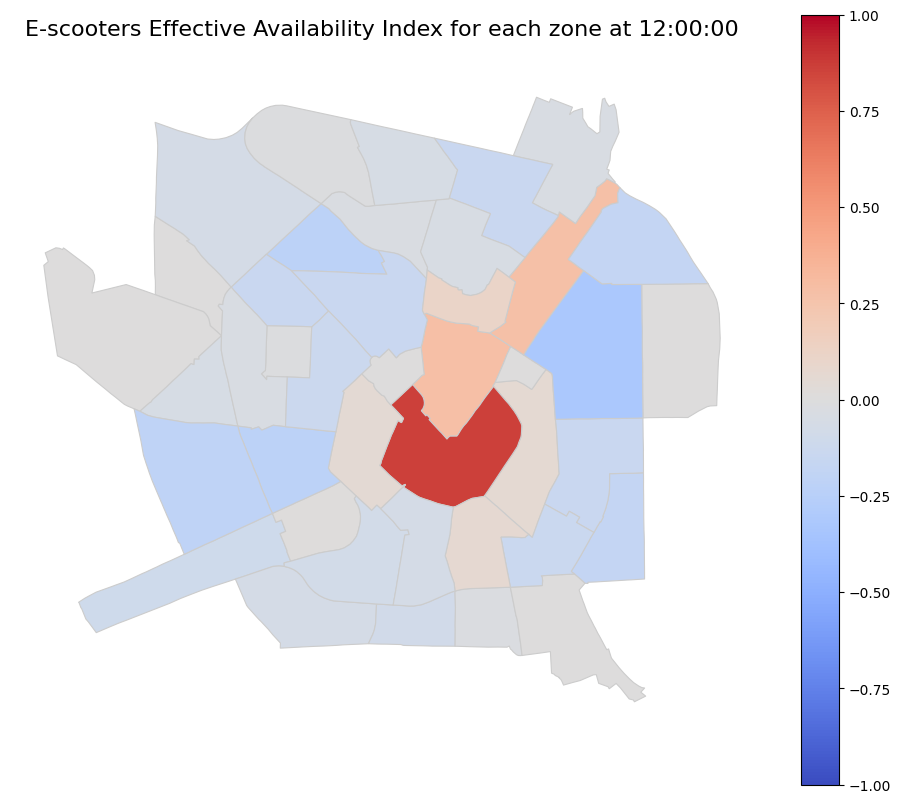

In [55]:
# Filter the DataFrame for the specific hour
specific_hour = 12
df_specific_hour = gdf_avg[gdf_avg['hour'] == specific_hour]

# Merge the filtered GeoDataFrame with the milan_nil GeoDataFrame
merged = gpd.sjoin(milan_nil, df_specific_hour, predicate = 'contains')

# Plot the choropleth map
fig, ax = plt.subplots(figsize = (12, 10))
merged.plot(column = 'demand', cmap = 'coolwarm', linewidth = 0.8, ax = ax, edgecolor = '0.8', legend = True, norm = plt.Normalize(vmin = -1, vmax = 1))
# Set the plot title and axis labels
plt.title('E-scooters Effective Availability Index for each zone at {}:00:00\n'.format(str(specific_hour).zfill(2)), fontsize = 16)
plt.axis('off')

# Save the map
plt.savefig('E-scooters effective availability index at h' + str(specific_hour))

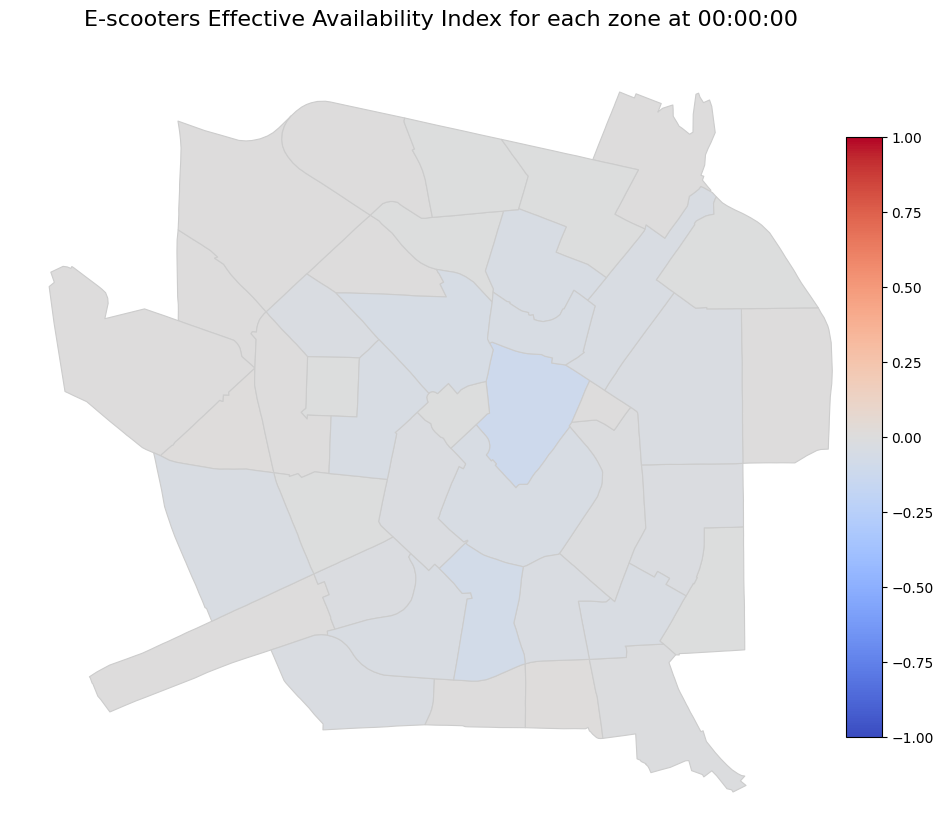

In [52]:
# Create a figure and axes for the map
fig, ax = plt.subplots(figsize = (12, 10))

# Define a function to update the map for each hour
def update_map(hour):
  ax.clear()
  df_specific_hour = gdf_avg[gdf_avg['hour'] == hour]
  merged = gpd.sjoin(milan_nil, df_specific_hour, predicate = 'contains')
  merged = merged[merged['hour'] == hour]
  merged.plot(column = 'demand', cmap = 'coolwarm', linewidth = 0.8, ax = ax, edgecolor = '0.8', legend = False,  norm = plt.Normalize(vmin = -1, vmax = 1))
  ax.set_title('E-scooters Effective Availability Index for each zone at {}:00:00\n'.format(str(hour).zfill(2)), fontsize = 16)
  ax.set_axis_off()

# Create the animated map
ani = animation.FuncAnimation(fig, update_map, frames = range(0, 24), interval = 750, repeat = True)

# Add a colorbar
cax = fig.add_axes([0.85, 0.2, 0.03, 0.6])
sm = plt.cm.ScalarMappable(cmap = 'coolwarm', norm = plt.Normalize(vmin = -1, vmax = 1))
sm.set_array([])
fig.colorbar(sm, cax = cax)

# Set up the writer and save the animation to an MP4 file
Writer = animation.writers['ffmpeg']
writer = Writer(fps = 1, metadata = dict(artist = 'Me'), bitrate = 1800)
# Set the aspect ratio to a finite positive value
ax.set_aspect('equal', adjustable = 'box')
ani.save('Hourly e-scooters effective availability index.mp4', writer = writer)